<a href="https://colab.research.google.com/github/shreekrishh/Quant/blob/main/Quantitative_techniques_for_financial_risk_assessment_a_comparative_approach_using_different_risk_measures_and_estimation_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from scipy.stats import norm, t, logistic

In [ ]:
import scipy

In [ ]:
tickers = ['AAPL', 'FISV', 'MA', 'INTU'] 
start = dt.datetime(2010,1,1)
end = dt.datetime(2018,1,1)

In [ ]:
alpha = 5

In [ ]:
initialPortfolio = 100000

#Portfolio Optimization to decide appropriate weights

In [ ]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns 

In [ ]:
def optimization(tickers, start, end):
  data = yf.download(tickers, start, end)['Close']
  returns = data.pct_change()

  annualized_mean = expected_returns.mean_historical_return(data)
  mean_daily_returns = annualized_mean/252

  annualized_cov_matrix = risk_models.sample_cov(data)
  cov_daily_matrix = annualized_cov_matrix/252

  ef = EfficientFrontier(annualized_mean, annualized_cov_matrix)
  weights = ef.max_sharpe()
  cleaned_weights = ef.clean_weights()

  performance = ef.portfolio_performance(verbose = True)
  
  return returns, mean_daily_returns, cov_daily_matrix, cleaned_weights, performance

In [ ]:
returns, mean_daily_returns, cov_daily_matrix, cleaned_weights, performance = optimization(tickers, start, end)
print(cleaned_weights, performance)

[*********************100%***********************]  4 of 4 completed
Expected annual return: 23.5%
Annual volatility: 16.8%
Sharpe Ratio: 1.28
OrderedDict([('AAPL', 0.20909), ('FISV', 0.54574), ('INTU', 0.13147), ('MA', 0.1137)]) (0.23496905147059027, 0.1683941291276839, 1.2765828154709076)


In [ ]:
weights = []
for i in range(len(cleaned_weights)):
  weights.append(cleaned_weights[tickers[i]])

In [ ]:
weights1 = np.asarray(weights)
weights1

array([0.20909, 0.54574, 0.1137 , 0.13147])

In [ ]:
weights2 = np.asarray([0.25, 0.25, 0.25, 0.25])
weights2

array([0.25, 0.25, 0.25, 0.25])

In [ ]:
returns.columns

Index(['AAPL', 'FISV', 'INTU', 'MA'], dtype='object')

In [ ]:
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

In [ ]:
Time = 1
pRet1, pStd1 = portfolioPerformance(weights1, mean_daily_returns, cov_daily_matrix, Time)
pRet2, pStd2 = portfolioPerformance(weights2, mean_daily_returns, cov_daily_matrix, Time)


In [ ]:
returns['portfolio_marko'] = returns.dot(weights1)


In [ ]:
returns['portfolio_equal_weights'] = returns[returns.columns[:-1]].dot(weights2)


In [ ]:
returns


,AAPL,FISV,INTU,MA,portfolio_marko,portfolio_equal_weights
Date,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.004248,0.000000,-0.002959,0.002291,0.000755
2010-01-06,-0.015906,-0.004230,-0.013957,-0.002031,-0.007488,-0.009031
2010-01-07,-0.001849,-0.004653,-0.003292,-0.006535,-0.004159,-0.004082
2010-01-08,0.006648,-0.011179,0.026420,0.000355,-0.001660,0.005561
...,...,...,...,...,...,...
2017-12-22,0.000000,-0.002373,-0.000756,0.002126,-0.001102,-0.000251
2017-12-26,-0.025370,0.008287,0.002713,0.002850,-0.000099,-0.002880
2017-12-27,0.000176,0.000685,-0.001258,0.000793,0.000372,0.000099


#Value At Risk (Var)
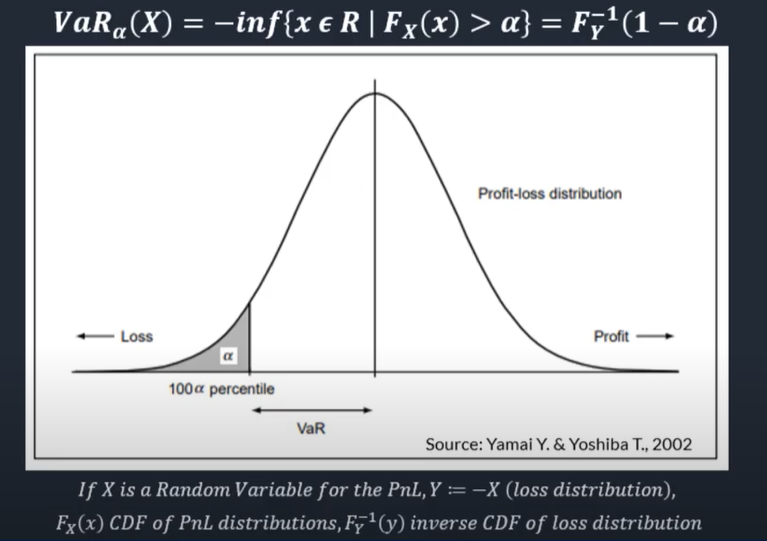

Value at risk tells us about the worst outcome given a certain confidence level, here alpha is confidence level. VAR is calculated on point estimates for which value of variable occurs. In trading, if i have a portfolio then my concern is what will be the maximum loss I will incur on next day/week/year. given certain confidence level. 
Note: inf in the formula is infinum, lowest number among all x in a set.

In [ ]:
# Historical Method to find VAR
def historicalVaR(returns, alpha=alpha):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")



hVaR_marko = -historicalVaR(returns['portfolio_marko'].dropna(), alpha=alpha)*np.sqrt(Time)
hVaR_equal = -historicalVaR(returns['portfolio_equal_weights'].dropna(), alpha=alpha)*np.sqrt(Time)


In [ ]:
print('Value at Risk for marko at 95th CI    :      ', round(initialPortfolio*hVaR_marko,2))
print('Value at Risk for equal weight at 95th CI    :      ', round(initialPortfolio*hVaR_equal,2))



Value at Risk for marko at 95th CI    :       1627.26
Value at Risk for equal weight at 95th CI    :       1754.97


In [ ]:
#Parametric method to find VAR
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=alpha, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        para_VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        para_VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return para_VaR


normVaR_marko = var_parametric(pRet1, pStd1)
tVaR_marko = var_parametric(pRet1, pStd1, distribution='t-distribution')
normVaR_equal = var_parametric(pRet2, pStd2)
tVaR_equal = var_parametric(pRet2, pStd2, distribution='t-distribution')


In [ ]:
print("t-dist VaR for marko at 95th CI       :      ", round(initialPortfolio*tVaR_marko,2))
print("Normalfor VaR for marko at 95th CI       :      ", round(initialPortfolio*normVaR_marko,2))
print("t-dist VaR for equal wights at 95th CI       :      ", round(initialPortfolio*tVaR_equal,2))
print("Normalfor VaR for equal weights at 95th CI       :      ", round(initialPortfolio*normVaR_equal,2))


t-dist VaR for marko at 95th CI       :       1593.28
Normalfor VaR for marko at 95th CI       :       1655.2
t-dist VaR for equal wights at 95th CI       :       1665.86
Normalfor VaR for equal weights at 95th CI       :       1730.47


<function matplotlib.pyplot.show>

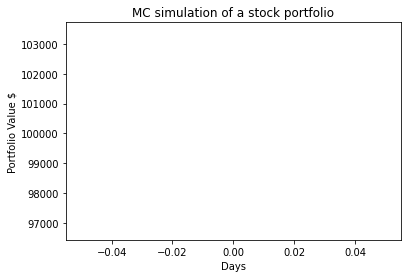

In [ ]:
# Monte Carlo Method for markowitz weighted portfolio to find var and cvar
mc_sims = 400 # number of simulations
meanM = np.full(shape=(Time, len(weights1)), fill_value=mean_daily_returns)
meanM = meanM.T
portfolio_sims = np.full(shape=(Time, mc_sims), fill_value=0.0)

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(Time, len(weights1)))
    L = np.linalg.cholesky(cov_daily_matrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights1, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value $')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show

In [ ]:
portResults1 = pd.Series(portfolio_sims[-1,:])
portResults1

0      101771.153094
1       99707.252568
2      102157.205559
3      101240.372882
4      100721.236543
           ...      
395     99113.720590
396     99367.244172
397    100415.109640
398    100104.530676
399     99352.331530
Length: 400, dtype: float64

<function matplotlib.pyplot.show>

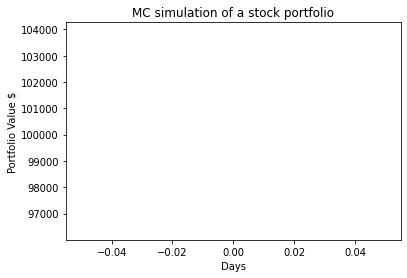

In [ ]:
# Monte Carlo Method for equally weighted portfolio to find var and cvar
mc_sims = 400 # number of simulations
meanM = np.full(shape=(Time, len(weights2)), fill_value=mean_daily_returns)
meanM = meanM.T
portfolio_sims = np.full(shape=(Time, mc_sims), fill_value=0.0)

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(Time, len(weights2)))
    L = np.linalg.cholesky(cov_daily_matrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights2, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value $')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show

In [ ]:
portResults2 = pd.Series(portfolio_sims[-1,:])
portResults2

0      100356.297717
1      100649.367055
2      100806.408393
3       99563.054979
4       99727.447557
           ...      
395    101172.761661
396    101019.955720
397    100259.675328
398    100430.039779
399    101432.837792
Length: 400, dtype: float64

In [ ]:
def mcVaR(returns, alpha=alpha):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")


final_value_var_marko = initialPortfolio - mcVaR(portResults1, alpha=alpha)
final_value_var_equal = initialPortfolio - mcVaR(portResults2, alpha=alpha)


In [ ]:
final_value_var_marko

1645.177292795328

In [ ]:
final_value_var_equal

1757.1078113613185

#Conditional Value at risk (CVar)
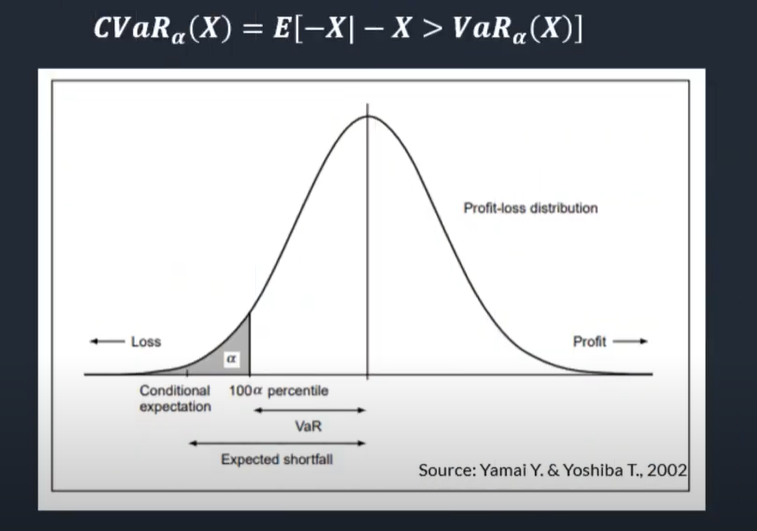

conditional Var also called as expected shortfall is a expected returns given portfolio will breach Var to downside. 

In [ ]:
#Historical method to find CVar
def historicalCVaR(returns, alpha=alpha):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")


hCVaR_marco = -historicalCVaR(returns['portfolio_marko'].dropna(), alpha=5)*np.sqrt(Time)
hCVaR_equal = -historicalCVaR(returns['portfolio_equal_weights'].dropna(), alpha=5)*np.sqrt(Time)


In [ ]:
print('Conditional VaR for marko weighted portfolio 95th CI  :      ', round(initialPortfolio*hCVaR_marco,2))
print('Conditional VaR for equal weighted portfolio 95th CI  :      ', round(initialPortfolio*hCVaR_equal,2))


Conditional VaR for marko weighted portfolio 95th CI  :       2436.2
Conditional VaR for equal weighted portfolio 95th CI  :       2510.41


In [ ]:
#parametric method to find cvar
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=alpha, dof=6):
    if distribution == 'normal':
        para_CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        para_CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return para_CVaR


normCVaR_marko = cvar_parametric(pRet1, pStd1)
tCVaR_marko = cvar_parametric(pRet1, pStd1, distribution='t-distribution')
normCVaR_equal = cvar_parametric(pRet2, pStd2)
tCVaR_equal= cvar_parametric(pRet2, pStd2, distribution='t-distribution')


In [ ]:
print("t-dist CVaR for marko portfolio at 95th CI       :      ", round(initialPortfolio*tCVaR_marko,2))
print("Normal CVaR for marko portfolio at 95th CI       :      ", round(initialPortfolio*normCVaR_marko,2))
print("t-dist CVaR for equal weighted portfolio at 95th CI       :      ", round(initialPortfolio*tCVaR_equal,2))
print("Normal CVaR for equal weighted portfolio at 95th CI       :      ", round(initialPortfolio*normCVaR_equal,2))


t-dist CVaR for marko portfolio at 95th CI       :       2198.76
Normal CVaR for marko portfolio at 95th CI       :       2099.42
t-dist CVaR for equal weighted portfolio at 95th CI       :       2297.61
Normal CVaR for equal weighted portfolio at 95th CI       :       2193.96


In [ ]:

def mcCVaR(returns, alpha=alpha):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

final_value_cvar_marko = initialPortfolio - mcCVaR(portResults1, alpha=alpha)
final_value_cvar_equal = initialPortfolio - mcCVaR(portResults2, alpha=alpha)


In [ ]:
final_value_cvar_marko

2173.0965045600024

In [ ]:
final_value_cvar_equal

2315.6658912909625

In [ ]:
returns

,AAPL,FISV,INTU,MA,portfolio_marko,portfolio_equal_weights
Date,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.004248,0.000000,-0.002959,0.002291,0.000755
2010-01-06,-0.015906,-0.004230,-0.013957,-0.002031,-0.007488,-0.009031
2010-01-07,-0.001849,-0.004653,-0.003292,-0.006535,-0.004159,-0.004082
2010-01-08,0.006648,-0.011179,0.026420,0.000355,-0.001660,0.005561
...,...,...,...,...,...,...
2017-12-22,0.000000,-0.002373,-0.000756,0.002126,-0.001102,-0.000251
2017-12-26,-0.025370,0.008287,0.002713,0.002850,-0.000099,-0.002880
2017-12-27,0.000176,0.000685,-0.001258,0.000793,0.000372,0.000099


In [ ]:
cagr_marko = np.sum(returns['portfolio_marko'])
cagr_equal = np.sum(returns['portfolio_equal_weights'])


#Loss Random Variable
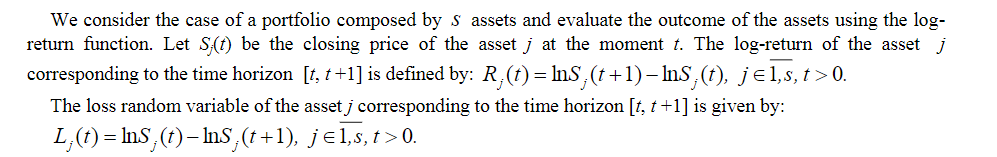

In [ ]:
def random_loss(df):
  LRV = 1/(df + 1)
  rand_loss = np.log(LRV)
  rand_loss = rand_loss.dropna()
  return pd.Series(rand_loss)




In [ ]:
rand_loss_marko = random_loss(returns['portfolio_marko'])
rand_loss_equal = random_loss(returns['portfolio_equal_weights'])

In [ ]:
rand_loss_marko

Date
2010-01-05   -0.002288
2010-01-06    0.007517
2010-01-07    0.004168
2010-01-08    0.001661
2010-01-11    0.000580
                ...   
2017-12-22    0.001102
2017-12-26    0.000099
2017-12-27   -0.000372
2017-12-28   -0.002873
2017-12-29    0.006768
Name: portfolio_marko, Length: 2012, dtype: float64

In [ ]:
from scipy.stats import anderson

In [ ]:
is_logistic_marko = anderson(rand_loss_marko, 'logistic')

In [ ]:
is_logistic_marko

AndersonResult(statistic=2.1924446384291514, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5]))

In [ ]:
is_logistic_equal = anderson(rand_loss_equal, 'logistic')

In [ ]:
is_logistic_equal

AndersonResult(statistic=3.2579239864762712, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5]))

#VAR and CVAR using logistic distribution method

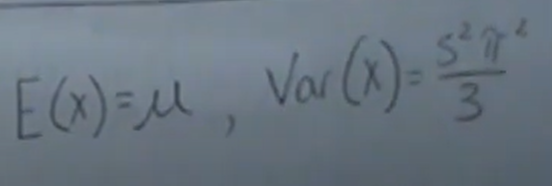


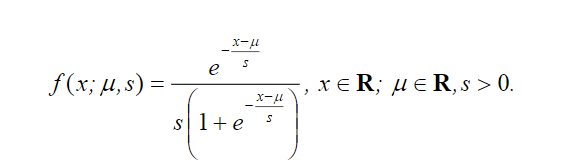

Here mu is a location parameter and s is a scale parameter of logistic distribution. Then we will use these formulas for calculating the VAR and CVAR

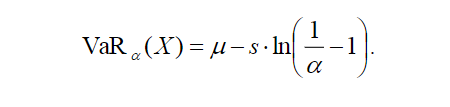

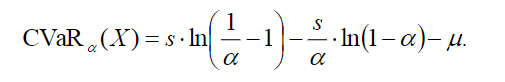

In [ ]:
mu_marko = rand_loss_marko.mean()
mu_equal = rand_loss_equal.mean()

In [ ]:
s_marko = np.sqrt((3*rand_loss_marko.var())/(np.pi**2))
s_equal = np.sqrt((3*rand_loss_equal.var())/(np.pi**2))


In [ ]:
var_log_marko = mu_marko - (s_marko * np.log((0.05)/0.95))
cvar_log_marko= ((s_marko*np.log(0.05/0.95))-((s_marko/0.95)*np.log(0.05)) - mu_marko)

In [ ]:
var_log_equal= mu_equal - (s_equal * np.log((0.05)/0.95))
cvar_log_equal= ((s_equal*np.log(0.05/0.95))-((s_equal/0.95)*np.log(0.05)) - mu_equal)

In [ ]:
var_log_marko

0.01639752816096106

In [ ]:
cvar_log_marko

0.002099424423957312

In [ ]:
var_log_equal

0.0171282250712135

In [ ]:
cvar_log_equal

0.002167077516890054

In [ ]:
 1.63% and 2.23%